This is my play with the Python ensemble sampling toolkit [emcee](https://github.com/dfm/emcee), created by Dan Foreman-Mackey, using Markov chain Monte Carlo method. For more details read [this publication](http://msp.org/camcos/2010/5-1/p04.xhtml).

## Dependences

To run the code you will need following libraries

* [emcee](https://github.com/dfm/emcee)
* [corner](https://pypi.python.org/pypi/corner/1.0.0)

To install libraries for Anacoda type `conda install lib_name`


## Disclaimer

Most of the code is based on [this example](http://dan.iel.fm/emcee/current/user/line/) from [emcee mans](http://dan.iel.fm/emcee/current/).



# Fitting a Model to Data using affine-invariant MCMC 

In [98]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
#import seaborn as sns
%matplotlib inline


import emcee
import corner

Create some syntetic data

In [54]:
# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# Generate some synthetic data from the model.
N = 50
x = np.sort(10*np.random.rand(N))
yerr = 0.1+0.5*np.random.rand(N)
y = m_true*x+b_true
y += np.abs(f_true*y) * np.random.randn(N)
y += yerr * np.random.randn(N)

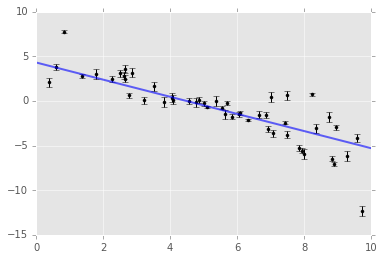

In [55]:
plt.errorbar(x,y,yerr=yerr,fmt=".k")
#plt.plot(y,'bo')
fig = plt.gcf()
#fig.set_size_inches(5,10)
#plt.axis('equal');

#show true model
x1 = np.array([0, 10])
plt.plot(x1,m_true*x1+b_true,'b',lw=2,alpha=.6);


The usual way to find best fit line is the use of closed equations (LSA).

In [77]:
A= np.vstack((np.ones_like(x),x)).T
v = np.diag(yerr*yerr) #L2 of errors

cov =  np.linalg.inv(A.T.dot(np.linalg.solve(v,A)))

b_ls,m_ls = cov.dot(A.T.dot(np.linalg.solve(v,y)))
print '''Our estimation was {:.3f},{:.3f}
Truth was {:.3f},{:.3f}
Diff is {:.3f},{:.3f}
'''.format(b_ls,m_ls,b_true,m_true,b_ls-b_true,m_ls-m_true)

Our estimation was 5.380,-1.096
Truth was 4.294,-0.959
Diff is 1.086,-0.137



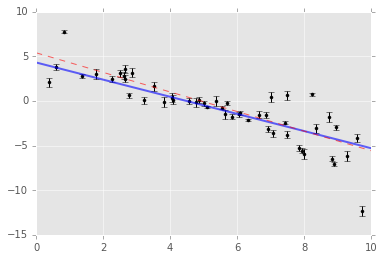

In [74]:
plt.errorbar(x,y,yerr=yerr,fmt=".k")
#plt.plot(y,'bo')
fig = plt.gcf()
#fig.set_size_inches(5,10)
#plt.axis('equal');

#show true model
x1 = np.array([0, 10])
plt.plot(x1,m_true*x1+b_true,'b',lw=2,alpha=.6);

#show LSA best fit model
plt.plot(x1,m_ls*x1+b_ls,'r--',lw=1,alpha=.6);

# Maximum likelihood estimation

LSA solution found is the Maximum likelihood estimation if error distribution is Gaussian (normal) and independent. As there in no such implementation of LSA, we will have to write down lm function and try to optimise it.
$\ln p(y | x,\sigma,m,b,f) = -\frac{1}{2} \sum_m \left[ \frac{(y_n - mx_n-b)^2}{s^2_n} + \ln(2\pi s^2_n) \right]$

$s^2_n=\sigma^2_n+f^2(mx_n+b)^2$

In [58]:
def lnlike(theta, x, y, yerr):
    m, b, lnf = theta
    model = m * x + b
    inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2*lnf))
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

A good way of finding this numerical optimum of this likelihood function is to use the *scipy.optimize* module. It will minimise function. As we want to maximise likelihood, we can do it by minimising the negative likelihood.
Lets plot results as well.

In [59]:
import scipy.optimize as op
chi2 = lambda *args: -2 * lnlike(*args)
result = op.minimize(chi2, [m_true, b_true, np.log(f_true)], args=(x, y, yerr))
m_ml, b_ml, lnf_ml = result["x"]
print("""Maximum likelihood result:
    m = {0} (truth: {1})
    b = {2} (truth: {3})
    f = {4} (truth: {5})
""".format(m_ml, m_true, b_ml, b_true, np.exp(lnf_ml), f_true))

Maximum likelihood result:
    m = -1.04416005602 (truth: -0.9594)
    b = 4.87088895224 (truth: 4.294)
    f = 0.562279962875 (truth: 0.534)



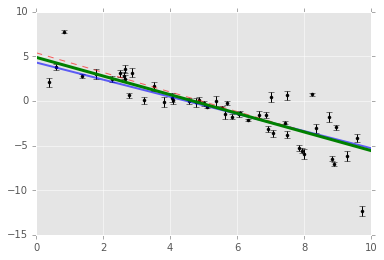

In [60]:
plt.errorbar(x,y,yerr=yerr,fmt=".k")
#plt.plot(y,'bo')
#plt.axis('equal');

#show true model
x1 = np.array([0, 10])
plt.plot(x1,m_true*x1+b_true,'b',lw=2,alpha=.6);

#show LSA best fit model
plt.plot(x1,m_ls*x1+b_ls,'r--',lw=1,alpha=.6);
#show ml best fit
plt.plot(x1,m_ml*x1+b_ml,'g',lw=3);

#fig = plt.gcf()
#fig.set_size_inches(10,3)

What we would like to visualise is the uncertities of parameters m,b. We will use MCMC as it allows us to find the posterior probability.

Lets start with posterior probability function

$p(m,b,g | x,y,\sigma) \alpha p(m,b,f)p(y | x,\sigma,m,b,f)$

We already have probability function $p(y | x,\sigma,m,b,f)$ so let's focus on prior function $p(m,b,f)$. We cannot draw parameter samples from our likelihood function so we will use uniform priors on m,b and log of f. 

In [61]:
#define priors
def lnprior(theta):
    m, b, lnf = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < lnf < 1.0:
        return 0.0
    return -np.inf
# using def:lnlike our log-prob function is
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

Lets sample defined distribution. We will first init walkers in Gaussian ball around the ML results.

In [78]:
#define and run walkers
import emcee

ndim, nwalkers = 3, 100 #params
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)] #starting point

print("Running MCMC...")
sampler.run_mcmc(pos, 500, rstate0=np.random.get_state())
print("Done.")


Running MCMC...
Done.


In [89]:
sampler.chain[:, :, 0]

array([[-1.04403377, -1.04394917, -1.04384367, ..., -0.93337038,
        -0.93337038, -0.94292481],
       [-1.04424985, -1.04423678, -1.04429836, ..., -1.03550274,
        -1.03550274, -1.01762471],
       [-1.04452751, -1.0444856 , -1.04448391, ..., -0.94377441,
        -0.94638199, -1.0431172 ],
       ..., 
       [-1.04403246, -1.04402196, -1.04409091, ..., -1.26115502,
        -1.26115502, -1.32039424],
       [-1.04425936, -1.04427076, -1.04427076, ..., -1.08414883,
        -1.0743283 , -1.0743283 ],
       [-1.04402057, -1.04405404, -1.04411093, ..., -0.9935974 ,
        -0.99338366, -0.9928926 ]])

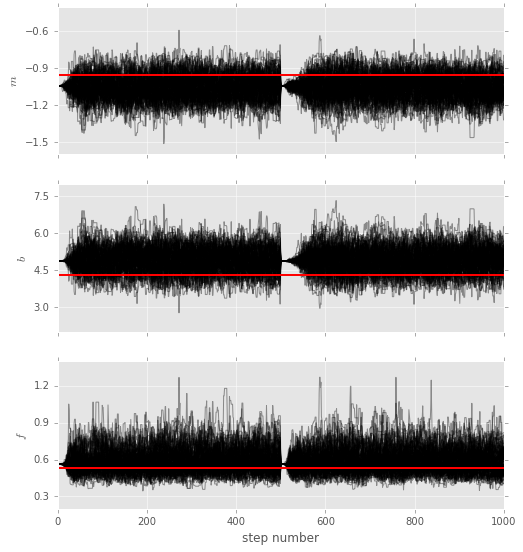

In [100]:
plt.clf()
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(8, 9))
axes[0].plot(sampler.chain[:, :, 0].T, color="k", alpha=0.4)
axes[0].yaxis.set_major_locator(MaxNLocator(5))
axes[0].axhline(m_true, color="r", lw=2)
axes[0].set_ylabel("$m$")

axes[1].plot(sampler.chain[:, :, 1].T, color="k", alpha=0.4)
axes[1].yaxis.set_major_locator(MaxNLocator(5))
axes[1].axhline(b_true, color="r", lw=2)
axes[1].set_ylabel("$b$")

axes[2].plot(np.exp(sampler.chain[:, :, 2]).T, color="k", alpha=0.4)
axes[2].yaxis.set_major_locator(MaxNLocator(5))
axes[2].axhline(f_true, color="r", lw=2)
axes[2].set_ylabel("$f$")
axes[2].set_xlabel("step number")


Plots above shows distribution of the walkers, with truth values shown in red. The walkers start in small distributions around the maximum likelihood values and then they quickly wander and start exploring the full posterior distribution.
Lets discard initial 50 steps to have uniformly distributed sample. 
We will then use corner plot to visualise our MCMC distribution.


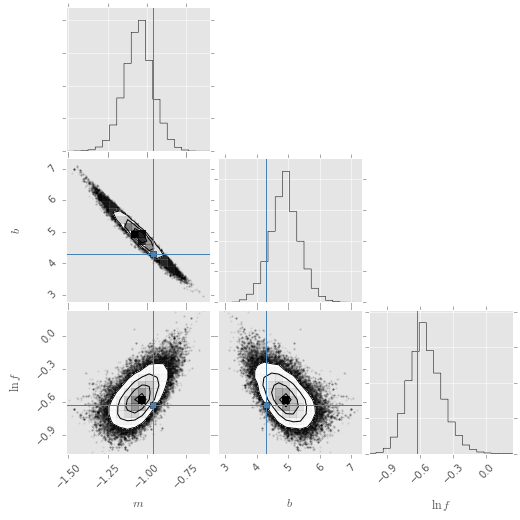

In [99]:
burnin = 50
samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=["$m$", "$b$", "$\ln\,f$"],
                      truths=[m_true, b_true, np.log(f_true)])

## Corner plot

The corner plot shows the marginalized distribution for each parameter independently in the histograms along the diagonal and then the marginalized two dimensional distributions in the other panels.

## Diagnostic plot

Another diagnostic plot is the projection of your results into the space of the observed data. To do this, you can choose a few (say 100 in this case) samples from the chain and plot them on top of the data points:

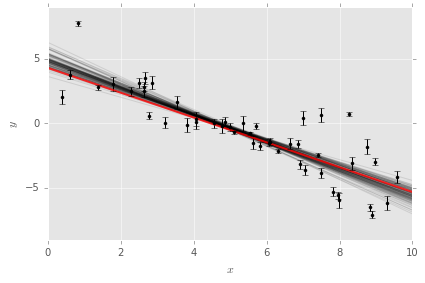

In [110]:
plt.figure()
for m, b, lnf in samples[np.random.randint(len(samples), size=100)]:
    plt.plot(xl, m*xl+b, color="k", alpha=0.1)
plt.plot(xl, m_true*xl+b_true, color="r", lw=2, alpha=0.8)
plt.errorbar(x, y, yerr=yerr, fmt=".k")
plt.ylim(-9, 9)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.tight_layout()

hich numbers should go in the abstract? There are a few different options for this but [Dan's](http://dan.iel.fm/emcee/current/user/line/) favorite is to quote the uncertainties based on the 16th, 50th, and 84th percentiles of the samples in the marginalized distributions. 

In [111]:
samples[:, 2] = np.exp(samples[:, 2])
m_mcmc, b_mcmc, f_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))
print("""MCMC result:
    m = {0[0]} +{0[1]} -{0[2]} (truth: {1})
    b = {2[0]} +{2[1]} -{2[2]} (truth: {3})
    f = {4[0]} +{4[1]} -{4[2]} (truth: {5})
""".format(m_mcmc, m_true, b_mcmc, b_true, f_mcmc, f_true))

MCMC result:
    m = -1.04976908901 +0.0881855258692 -0.0926997538204 (truth: -0.9594)
    b = 4.87398131612 +0.473788695383 -0.433514478795 (truth: 4.294)
    f = 0.570329433488 +0.0984329823456 -0.0716354957842 (truth: 0.534)

